Assuming that a cart has mass $M$, the pendulum at the end of a massless rod is $m$, the equations of motion we get from Lagrangian mechanics is $$(M+m)\ddot x - ml\ddot \theta cos(\theta) + ml\dot \theta^2 sin(\theta) = F(t)$$
$$l\ddot \theta - \ddot x cos(\theta) - gsin(\theta) = 0$$
where $F(t)$ is the applied force to the cart. We will assume that $F(t) = 0$ for the simplest example of a still cart.

First, import the packages:

In [27]:
%matplotlib notebook
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Define the constants:

In [28]:
M = 50
m = 0.2
l = 1
g = 9.81
F = 0

To use the "solve_ivp" feature of SciPy, we need to split the two second-order ODEs to four first order ODEs. We get that $\dot x$ and $\dot \theta$ are given, and that
$$\ddot \theta = \frac{(M+m)gsin\theta + ml \dot \theta^2 sin\theta cos\theta - F(t)cos\theta}{l(M + m + mcos^2\theta)}$$
$$\ddot x = \frac{gsin\theta - l \ddot \theta}{cos\theta}$$

In [29]:
def equations(t, y):
    x, xdot, theta, thetadot = y
    thetaddot = (M + m)*g*np.sin(theta) + m*l*thetadot*thetadot*np.sin(theta)*np.cos(theta) - F*np.cos(theta)
    thetaddot /= l * (M + m + m*np.cos(theta)*np.cos(theta))
    xddot = g*np.sin(theta) - l*thetaddot
    xddot /= np.cos(theta)
    return [xdot, xddot, thetadot, thetaddot]

In [30]:
initials = [0, 0, 0.3, 0]
t_span = [0, 20]

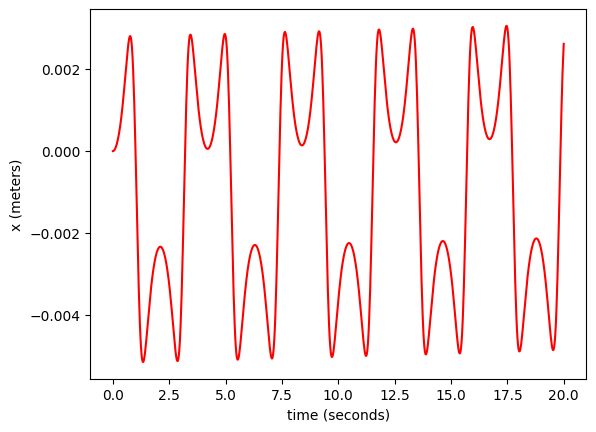

In [31]:
fig, axs = plt.subplots(1)

solution = solve_ivp(equations, t_span, initials, t_eval=np.linspace(0, 20, 800), method='RK45')
axs.set_xlabel("time (seconds)")
axs.set_ylabel("x (meters)")
axs.plot(solution.t, solution.y[0], color='r') # x over time
fig.savefig('images/basicpendulumplot.png', bbox_inches='tight')

dt = 0.025

In [32]:
fig, ax = plt.subplots()

plt.xlim(-3, 3)
plt.ylim(-2, 2)
cart_width = 0.4
cart_height = 0.2

cart_width = 0.4
cart_height = 0.2
cart = Rectangle((-cart_width/2, -cart_height/2), cart_width, cart_height, color='black')
ax.add_patch(cart)

pendulum_line, = ax.plot([], [], 'k-', lw=2)
pendulum_bob, = ax.plot([], [], 'ro', markersize=10)

def init():
    cart.set_xy((-cart_width/2, -cart_height/2))
    pendulum_line.set_data([], [])
    pendulum_bob.set_data([], [])
    return cart, pendulum_line, pendulum_bob

def update(frame):
    x = solution.y[0, frame]
    theta = solution.y[2, frame]
    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])
    return cart, pendulum_line, pendulum_bob

ani = FuncAnimation(fig, update, frames=len(solution.t), init_func=init, blit=True, interval=25)
plt.grid(True)
#plt.show()
plt.close()
HTML(ani.to_html5_video())

Now that we know how to simulate an inverted pendulum (or just a normal pendulum under specific conditions), we will attempt to implement a PID control system to stabilize the inverted pendulum. There are libraries for this, but unlike some of the methods used in this project (Runge-Kutta, root-finding, etc), we have not covered any control theory. Thus, I will try to construct my own PID system.

We want to minimize the angle of the bob of the pendulum from the vertical, so we say that for a given point in time, the error is $\pi - \theta$ (here $\pi$ is where the vertical is). The bigger the angle from the vertical, the bigger the error is, and thus the more the PID tries to control the cart.

The high-level goals for implementing a PID controller is
1. Make sure that every frame returns an error, which is $\pi - \theta$.
2. Implement a PID controller that spits out a force $F$ with arbitrary weights (the fine-tuning can come later).
3. Update the ODEs with a new $F$ value.

To be able to tackle the first step, we need to modify the update function such that it will handle one frame to another, instead of handling all frames at once. This is needed because each frame will update the ODE solutions.

In [33]:
def new_equations(t, y, F): # only difference is that it takes F as an argument instead of the global variable F
    x, xdot, theta, thetadot = y
    thetaddot = (M + m)*g*np.sin(theta) + m*l*thetadot*thetadot*np.sin(theta)*np.cos(theta) - F*np.cos(theta)
    thetaddot /= l * (M + m + m*np.cos(theta)*np.cos(theta))
    xddot = g*np.sin(theta) - l*thetaddot
    xddot /= np.cos(theta)
    return [xdot, xddot, thetadot, thetaddot]

def dummy_update(frame):
    global new_solution
    
    if frame == 0:
        new_solution = solve_ivp(new_equations, [0, dt], initials, args=(0,), method='RK45')
    x = new_solution.y[0, -1]
    dx = new_solution.y[1, -1]
    theta = new_solution.y[2, -1]
    dtheta = new_solution.y[3, -1]

    # dummy oscillatory force
    F = 1 * frame
    if frame % 100 >= 50:
        F *= -1

    new_solution = solve_ivp(new_equations, [frame * dt, (frame + 1) * dt], [x, dx, theta, dtheta], args=(F,), method='RK45')
    if frame % 50 == 0:
        print("Frame " + str(frame) + " out of " + str(20 / dt))

    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])
    return cart, pendulum_line, pendulum_bob

In [34]:
ani = FuncAnimation(fig, dummy_update, frames=int(20/dt), init_func=init, blit=True, interval=25)
plt.grid(True)
#plt.show()
plt.close()
HTML(ani.to_html5_video())

Frame 0 out of 800.0
Frame 50 out of 800.0
Frame 100 out of 800.0
Frame 150 out of 800.0
Frame 200 out of 800.0
Frame 250 out of 800.0
Frame 300 out of 800.0
Frame 350 out of 800.0
Frame 400 out of 800.0
Frame 450 out of 800.0
Frame 500 out of 800.0
Frame 550 out of 800.0
Frame 600 out of 800.0
Frame 650 out of 800.0
Frame 700 out of 800.0
Frame 750 out of 800.0


Now that we know how to update forces for the ODE solver every frame, we will now figure out a way to implement a PID control system.

First, we want to be able to pass the error, its integral in the time range $[0, t]$, and its approximate time derivative.

Notice that this is all discretized, so for the integral, it suffices to approximate using trapezoidal sums. For the derivative, we can approximate the behavior of the system such that taking the derivative is just taking the slope from the previous state (which is 0.025 seconds before) to the current state.

In [35]:
def trapezoid_int(dt, vals):
    sum = 0
    for i in range(len(vals) - 1):
        sum += (vals[i] + vals[i + 1]) * dt / 2
    return sum

def basic_pid_control(theta_error, theta_gains, max_force = 10000):
    # theta PID
    theta_p = theta_error[-1] * theta_gains[0]
    if len(theta_error) > 1:
        theta_i = trapezoid_int(dt, theta_error) * theta_gains[1]
        theta_d = ((theta_error[-1] - theta_error[-2]) / dt) * theta_gains[2]
    else:
        theta_i = 0
        theta_d = 0

    force = (theta_p + theta_i + theta_d)
    force = np.clip(force, -max_force, max_force)
    return force

print(basic_pid_control([0.1, 0.005, 0.1], [0.2, 0, 2]))

7.619999999999999


Let's try to incorporate this very basic PID control system on our update function.

In [36]:
fig, ax = plt.subplots()

cart_width = 0.4
cart_height = 0.2

cart_width = 0.4
cart_height = 0.2
cart = Rectangle((-cart_width/2, -cart_height/2), cart_width, cart_height, color='black')
ax.add_patch(cart)

pendulum_line, = ax.plot([], [], 'k-', lw=2)
pendulum_bob, = ax.plot([], [], 'ro', markersize=10)

def init():
    cart.set_xy((-cart_width/2, -cart_height/2))
    pendulum_line.set_data([], [])
    pendulum_bob.set_data([], [])

    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    return cart, pendulum_line, pendulum_bob

def pid_update_v1(frame):
    global new_solution
    global theta_error
    
    if frame == 0:
        new_solution = solve_ivp(new_equations, [0, dt], initials, args=(0,), method='RK45')
        theta_error = []
    x = new_solution.y[0, -1]
    dx = new_solution.y[1, -1]
    theta = new_solution.y[2, -1]
    dtheta = new_solution.y[3, -1]

    theta_error.append(np.pi - theta)
    F = basic_pid_control(theta_error, [10, 0, 0])

    new_solution = solve_ivp(new_equations, [frame * dt, (frame + 1) * dt], [x, dx, theta, dtheta], args=(F,), method='RK45')
    if frame % 50 == 0:
        print("Frame " + str(frame) + " out of " + str(20 / dt))

    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])

    return cart, pendulum_line, pendulum_bob

ani = FuncAnimation(fig, pid_update_v1, frames=int(20/dt), init_func=init, blit=True, interval=25)
plt.grid(True)
#plt.show()
plt.close()
HTML(ani.to_html5_video())

Frame 0 out of 800.0
Frame 50 out of 800.0
Frame 100 out of 800.0
Frame 150 out of 800.0
Frame 200 out of 800.0
Frame 250 out of 800.0
Frame 300 out of 800.0
Frame 350 out of 800.0
Frame 400 out of 800.0
Frame 450 out of 800.0
Frame 500 out of 800.0
Frame 550 out of 800.0
Frame 600 out of 800.0
Frame 650 out of 800.0
Frame 700 out of 800.0
Frame 750 out of 800.0


What is shown above is an attempt at PID control with a naive set of gain parameters. We will do manual self-tuning since automatic tuning is vulnerable to missing the correct gains due to the sensitivity of the inverted pendulum. I will be benchmarking specific milestones.

For an initial offset angle of 0.3 radians, with initial theta gain values of (10, 0, 2), slowly turning the theta proportional gain to 60 yielded stabilization, and for better-damped oscillations, I increased the derivative gain to 4:

In [37]:
M = 50
m = 0.2
l = 1
g = 9.81

fig, ax = plt.subplots()

cart_width = 0.4
cart_height = 0.2

cart_width = 0.4
cart_height = 0.2
cart = Rectangle((-cart_width/2, -cart_height/2), cart_width, cart_height, color='black')
ax.add_patch(cart)

pendulum_line, = ax.plot([], [], 'k-', lw=2)
pendulum_bob, = ax.plot([], [], 'ro', markersize=10)

def init():
    cart.set_xy((-cart_width/2, -cart_height/2))
    pendulum_line.set_data([], [])
    pendulum_bob.set_data([], [])

    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    return cart, pendulum_line, pendulum_bob

def pid_update_test(frame):
    global new_solution
    global theta_error
    global theta_history
    
    if frame == 0:
        new_solution = solve_ivp(new_equations, [0, dt], initials, args=(0,), method='RK45')
        theta_error = []
        theta_history = []
        x_error = []
    x = new_solution.y[0, -1]
    dx = new_solution.y[1, -1]
    theta = new_solution.y[2, -1]
    dtheta = new_solution.y[3, -1]

    theta_history.append(theta)
    
    theta_error.append(((np.pi - theta + np.pi) % (2*np.pi)) - np.pi)
    F = basic_pid_control(theta_error, [60, 0, 8])

    new_solution = solve_ivp(new_equations, [frame * dt, (frame + 1) * dt], [x, dx, theta, dtheta], args=(F,), method='RK45')
    if frame % 50 == 0:
        print("Frame " + str(frame) + " out of " + str(20 / dt))

    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])

    ax.set_xlim(x - 3, x + 3)
    return cart, pendulum_line, pendulum_bob

ani = FuncAnimation(fig, pid_update_test, frames=int(20/dt), init_func=init, blit=True, interval=25)
plt.grid(True)
plt.title(r'$M = 50, m = 0.2, l = 1.0, \theta_{t = 0} = 0.3$')
#plt.show()
plt.close()
HTML(ani.to_html5_video())

Frame 0 out of 800.0
Frame 50 out of 800.0
Frame 100 out of 800.0
Frame 150 out of 800.0
Frame 200 out of 800.0
Frame 250 out of 800.0
Frame 300 out of 800.0
Frame 350 out of 800.0
Frame 400 out of 800.0
Frame 450 out of 800.0
Frame 500 out of 800.0
Frame 550 out of 800.0
Frame 600 out of 800.0
Frame 650 out of 800.0
Frame 700 out of 800.0
Frame 750 out of 800.0


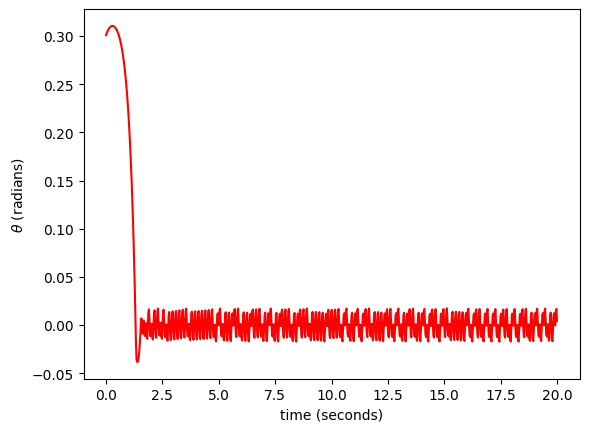

In [38]:
plt.xlabel("time (seconds)")
plt.ylabel(r'$\theta$ (radians)')
plt.plot(np.linspace(0, 20, 800), theta_history, color='r')
plt.savefig('images/pidpendulumplot.png', bbox_inches='tight')

The following cells are for presentation purposes. You can ignore them.

In [ ]:
M = 15
m = 5
l = 1.5
initials = [0, 0, 0.6, 0]

fig, ax = plt.subplots()

cart_width = 0.4
cart_height = 0.2

cart_width = 0.4
cart_height = 0.2
cart = Rectangle((-cart_width/2, -cart_height/2), cart_width, cart_height, color='black')
ax.add_patch(cart)

pendulum_line, = ax.plot([], [], 'k-', lw=2)
pendulum_bob, = ax.plot([], [], 'ro', markersize=10)

def init():
    cart.set_xy((-cart_width/2, -cart_height/2))
    pendulum_line.set_data([], [])
    pendulum_bob.set_data([], [])

    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    return cart, pendulum_line, pendulum_bob

def pid_update_test_2(frame):
    global new_solution
    global theta_error
    
    if frame == 0:
        new_solution = solve_ivp(new_equations, [0, dt], initials, args=(0,), method='RK45')
        theta_error = []
    x = new_solution.y[0, -1]
    dx = new_solution.y[1, -1]
    theta = new_solution.y[2, -1]
    dtheta = new_solution.y[3, -1]

    theta_error.append(((np.pi - theta + np.pi) % (2*np.pi)) - np.pi)
    F = basic_pid_control(theta_error, [60, 0.1, 6])
    new_solution = solve_ivp(new_equations, [frame * dt, (frame + 1) * dt], [x, dx, theta, dtheta], args=(F,), method='RK45')
    if frame % 50 == 0:
        print("Frame " + str(frame) + " out of " + str(20 / dt))

    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])

    ax.set_xlim(x - 3, x + 3)
    return cart, pendulum_line, pendulum_bob

ani = FuncAnimation(fig, pid_update_test_2, frames=int(20/dt), init_func=init, blit=True, interval=25)
plt.grid(True)
plt.title(r'$M = 15, m = 5, l = 1.5, \theta_0 = 0.6$')
#plt.show()
plt.close()
HTML(ani.to_html5_video())

Frame 0 out of 800.0
Frame 50 out of 800.0
Frame 100 out of 800.0


In [ ]:
M = 20
m = 3
l = 0.6
initials = [0, 0, 0.5, 0]

fig, ax = plt.subplots()

cart_width = 0.4
cart_height = 0.2

cart_width = 0.4
cart_height = 0.2
cart = Rectangle((-cart_width/2, -cart_height/2), cart_width, cart_height, color='black')
ax.add_patch(cart)

pendulum_line, = ax.plot([], [], 'k-', lw=2)
pendulum_bob, = ax.plot([], [], 'ro', markersize=10)

def init():
    cart.set_xy((-cart_width/2, -cart_height/2))
    pendulum_line.set_data([], [])
    pendulum_bob.set_data([], [])

    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    return cart, pendulum_line, pendulum_bob

def pid_update_test_3(frame):
    global new_solution
    global theta_error
    
    if frame == 0:
        new_solution = solve_ivp(new_equations, [0, dt], initials, args=(0,), method='RK45')
        theta_error = []
    x = new_solution.y[0, -1]
    dx = new_solution.y[1, -1]
    theta = new_solution.y[2, -1]
    dtheta = new_solution.y[3, -1]

    theta_error.append(((np.pi - theta + np.pi) % (2*np.pi)) - np.pi)
    F = basic_pid_control(theta_error, [60, 0, 4])
    new_solution = solve_ivp(new_equations, [frame * dt, (frame + 1) * dt], [x, dx, theta, dtheta], args=(F,), method='RK45')
    if frame % 50 == 0:
        print("Frame " + str(frame) + " out of " + str(20 / dt))

    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])

    ax.set_xlim(x - 3, x + 3)
    return cart, pendulum_line, pendulum_bob

ani = FuncAnimation(fig, pid_update_test_3, frames=int(20/dt), init_func=init, blit=True, interval=25)
plt.grid(True)
plt.title(r'$M = 20, m = 3, l = 0.6, \theta_0 = 0.5$')
#plt.show()
plt.close()
HTML(ani.to_html5_video())

In [ ]:
M = 5
m = 30
l = 1.2
initials = [0, 0, 0.4, 0]

fig, ax = plt.subplots()

cart_width = 0.4
cart_height = 0.2

cart_width = 0.4
cart_height = 0.2
cart = Rectangle((-cart_width/2, -cart_height/2), cart_width, cart_height, color='black')
ax.add_patch(cart)

pendulum_line, = ax.plot([], [], 'k-', lw=2)
pendulum_bob, = ax.plot([], [], 'ro', markersize=10)

def init():
    cart.set_xy((-cart_width/2, -cart_height/2))
    pendulum_line.set_data([], [])
    pendulum_bob.set_data([], [])

    ax.set_xlim(-3, 3)
    ax.set_ylim(-2, 2)
    return cart, pendulum_line, pendulum_bob

def pid_update_test_4(frame):
    global new_solution
    global theta_error
    
    if frame == 0:
        new_solution = solve_ivp(new_equations, [0, dt], initials, args=(0,), method='RK45')
        theta_error = []
    x = new_solution.y[0, -1]
    dx = new_solution.y[1, -1]
    theta = new_solution.y[2, -1]
    dtheta = new_solution.y[3, -1]

    theta_error.append(((np.pi - theta + np.pi) % (2*np.pi)) - np.pi)
    F = basic_pid_control(theta_error, [65, 0, 6])
    new_solution = solve_ivp(new_equations, [frame * dt, (frame + 1) * dt], [x, dx, theta, dtheta], args=(F,), method='RK45')
    if frame % 50 == 0:
        print("Frame " + str(frame) + " out of " + str(20 / dt))

    cart.set_xy((x - cart_width/2, -cart_height/2))
    pendulum_line.set_data([x, x + l * np.sin(theta)], 
                          [0, l * np.cos(theta)])
    pendulum_bob.set_data([x + l * np.sin(theta)], 
                         [l * np.cos(theta)])

    ax.set_xlim(x - 3, x + 3)
    return cart, pendulum_line, pendulum_bob

ani = FuncAnimation(fig, pid_update_test_4, frames=int(20/dt), init_func=init, blit=True, interval=25)
plt.grid(True)
plt.title(r'$M = 5, m = 30, l = 1.2, \theta_0 = 0.4$')
#plt.show()
plt.close()
HTML(ani.to_html5_video())